In [1]:
import os
# Disable tokenizers parallelism
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [2]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 8.3 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.2.1
    Uninstalling accelerate-1.2.1:
      Successfully uninstalled accelerate-1.2.1


In [3]:
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from torch.cuda import amp
from transformers import AutoModel, AutoTokenizer,AutoConfig
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
import torch
import warnings
import random
warnings.filterwarnings('ignore')
from collections import defaultdict
import torch.nn as nn
from transformers import get_scheduler
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from collections import defaultdict
import gc
gc.enable()

In [4]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

In [5]:
splits = {'train': 'tamil_train_cleaned.csv', 'val': 'tamil_val_cleaned.csv','test':'tamil_test_cleaned.csv'}
train_df = pd.read_csv("hf://datasets/kcrl/Shared_task_Tamil/" + splits["train"])
val_df = pd.read_csv("hf://datasets/kcrl/Shared_task_Tamil/" + splits["val"])
test_df = pd.read_csv("hf://datasets/kcrl/Shared_task_Tamil/" + splits["test"])

In [6]:
with pd.option_context('display.max_colwidth',0):
    display(train_df.sample(n=10))

,content,labels
3755,"பாஜக வை ஏன் விமர்சிக்கவில்லை ?\n\nகடைசிவரை பாஜகவோடு கூட்டணியில் இருந்துவிட்டு வெளியேறியுள்ளோம், என்னத்த விமர்சிப்பது. நாங்கள் திமுக போல அல்ல, கூட்டணி தர்மத்தை கடைபிடிக்கும் கட்சி அதிமுக\n\nஅய்யா அங்குசாமி, இதத்தான்யா கள்ளக்கூட்டணி ன்னு சொல்றோம்.\n\nஒப்புதல் வாக்குமூலத்திற்கு நன்றி.",Sarcastic
738,"watch | ""என்னையும், எங்கப்பா இடத்துல வச்சி பாக்குறாங்க"" \n\n- வீரப்பன் மகளும், ntk கிருஷ்ணகிரி வேட்பாளருமான வித்யா பேட்டி \n\nsunnews | ntk | seeman | krishnagiri",Opinionated
2171,திமுக அரசின் அதிகார அடக்குமுறை! கண்டிப்பாக வள்ளலார் வழி மெய்யன்பர்களும் தக்கப்பாடம் புகட்டுவார்கள்! கொதீக்கும் சீமான்!\n\ndmk mkstalin vadalurvallalarperuveli seeman \n\n\n\n,Positive
3443,catch nettrikan in today on \n\nதமிழக மக்களுக்கு துரோகம் இழைத்தவர் eps- ஸ்டாலின்\n\nமக்கள் செல்வாக்கை இழந்துவிட்டார் ஸ்டாலின்- eps\n\nதேர்தல் களத்தில் தேர்ச்சி பெறுவது யார்?\nedappadipalanisami mkstalin aiadmk dmk congress bjp annamalai\n\n,Negative
1143,பார்க்கும் முன்பே லைக் போட்டுட்டேன் நண்பா,None of the above
293,"mp, mla என எந்த பதவியும் இல்லாத போதே கோடிக்கணக்கில் சம்பாதிக்கும் அண்ணாமலை! பொறுப்பு கிடைத்தால் என்ன ஆகும் !சவுக்கு சங்கர் கேள்வி \nannamalai dmk savukkushankar annamalai admk bjp election",Negative
1296,நல்ல அப்பனுக்கு ஆத்தாளுக்கு பிறந்த முதல்வர் கேரளாவை ஆழ்வதால் அங்கு மலைகளை வெட்ட தடை.\n\n- யாரோ! \ndmkfailstn திமுக_நாட்டுக்கும்_வீட்டுக்கும்_கேடு \nஒரு_வயசான_திருட்டுப்பய,Sarcastic
2219,"பட்டினத்தார் போலான ஜெயலலிதாவின் பர்ஷனல் உதவியாளர்: எடப்பாடி, பன்னீர் பற்றி போட்ட நெத்தியடி கமெண்ட்…\n\nedappadipalanisamy edappadi eps admk jayalalitha poongundran opannerselvam sasikala\n",Substantiated
3693,சீமானை வீழ்த்த நடக்கும் சதி! திமுக கூலிப்படையினரின் கோழைத்தனம் : இடும்பாவனம் கார்த்திக்\n\nகாணொளி: \n\ntamilnadu seeman naamtamilar dmk dmkfails dmkalliance mkstalin udhayanidhi,Negative
1314,மக்களின்_சின்னம்_மைக்\nmike_voiceofpeople\n_______________________\nபல எழுச்சிகளும் புரட்சிகளும் வரலாறு முழுக்க உருவாக உறுதுணையாக இருந்தது ஒலிவாங்கி.\n\nதமிழக அரசியல் அமைப்பை மாற்ற நினைக்கும் நாம் தமிழர் கட்சியின் சின்னம் ஒலிவாங்கி.\nமக்களின்_சின்னம்_மைக்\nmike_voiceofpeople,Neutral


In [7]:
with pd.option_context('display.max_colwidth',0):
    display(val_df.sample(n=5))

,content,labels
494,நாம் தமிழர் ஆட்சியில் \nபெண்களின் பாதுகாப்பு உறுதி செய்யப்படும் . \n\n-செந்தமிழன் சீமான் \nதலைமை ஒருங்கிணைப்பாளர்\n\n\nமக்களின்_சின்னம்_மைக்\nmike_voiceofpeople\nelections2024\nதிருவண்ணாமலை,Positive
318,நீதான் தைரியமான ஆளாச்சே எங்க சொல்லு பார்க்கலாம்\ndmkfailstn \n\nadmk_cbe_south \n,Opinionated
98,மாநிலங்களின் விருப்பத்திற்கேற்ப நீட் தேர்வு நடைபெறும் என தேர்தல் காங்கிரஸ் அறிக்கையில் கூறுவது நாடகம் - சீமான் \n\nseeman | ntk | loksabhaelection2024 | electionswithibctamil,Opinionated
150,*தமிழக அரசியலில் மாற்றம் அதுவும் கோவையிலிருந்தே துவங்குகிறது.*\n\ndmkfailstn dravidianmodelfails,Opinionated
376,"newsupdate | சீமானுக்கு சின்னமும் இல்லை, வாக்கும் இல்லை - பாஜக மாநில தலைவர் அண்ணாமலை கிண்டல்\n\nseeman | annamalai | ntk | bjp | parliamentelection | newstamil24x7",Substantiated


In [8]:
train_df.labels.unique()

array(['Neutral', 'Substantiated', 'Opinionated', 'Positive', 'Sarcastic',
       'Negative', 'None of the above'], dtype=object)

In [9]:
labeling = {
    'Neutral': 0,
    'Substantiated': 1,
    'Opinionated': 2,
    'Positive' : 3,
    'Sarcastic': 4,
    'Negative': 5,
    'None of the above': 6
}
train_df['labels'] = train_df['labels'].apply(lambda x : labeling[x])
test_df['labels'] = test_df['labels'].apply(lambda x : labeling[x])
val_df['labels'] = val_df['labels'].apply(lambda x : labeling[x])

In [10]:
with pd.option_context('display.max_colwidth',0):
    display(train_df.sample(n=5))

,content,labels
478,மக்களின்_சின்னம்_மைக்\nmike_voiceofpeople எ\nஎன்ற கொத்துக்குறியைப் பயன்படுத்தி அனைவரும் தங்கள் கருத்துக்களைப் பதிவிடவும்!,2
3810,அ.தி.மு.க சார்பில் நாளை இப்தார் நோன்பு திறப்பு | admk | newsj\naiadmk aiadmknews edappadipalanisamy edappadi eid ramadankareem ramadan ramadan2024 newsj \n |\n |\n | \n| | \n |,2
1463,மீண்டும் திமுக விற்கு வாக்களித்தால். உங்கள் வாழிடத்திற்கு உத்திரவாதம் கிடையாது. \n\ndmkfailstn dmkfails,2
4215,அதிகாரம் மிகவும் வலிமையானது அதை அடைந்து விட்டால் எல்லாம் எளிமையாது!\n\nமக்களின்_சின்னம்_மைக்\n\nநாம்தமிழர்கட்சி,4
1082,"உலக தலைவர்களும், தொழில்\nஅதிபர்களும் பாராட்டும் மோடிக்கு\nஉங்கள் ஓட்டா?\n\nஇல்லை\n\nஉள்ளூர் கோப்பையை பார்த்து\nஏமார்ந்தவர்களுக்கு உங்கள்\nஓட்டா? \nகஞ்சாநிதி novotetodmk\n\ndrug_mafia_dmk dmkfailstn\ncongressmuktbharat edraid",2


In [11]:
with pd.option_context('display.max_colwidth',0):
    display(val_df.sample(n=5))

,content,labels
395,"நமது நாட்டை முன்னோக்கி கொண்டு செல்லக்கூடிய தனித்துவமான கண்ணோட்டங்களும் யோசனைகளும் இளைஞர்களிடம் உள்ளன. உங்கள் உரிமையை சரியாக கையாளுங்கள், வாக்களிக்கும் வாய்ப்பை ஒருபோதும் தவறவிடாதீர்கள்!\nyouthpower youngleaders empoweredyouth youthvotematters election2024 tnelection2024",3
139,நேரிடியாக தனது ஆதரவை பாடலின் மூலம் *நாம் தமிழர் கட்சியின் மைக் சின்னத்திற்கு* வாக்கு கேட்டு *அண்ணன் விஜய்* அவர்கள் பாடிய பாடல். \n\nகேம்பைன தான் தொறக்கட்டுமா.\n*மைக் க கையில் எடுக்கட்டுமா.*\n\nஎன்று பாடியுள்ளார்\nமக்களின்_சின்னம்_மைக்,4
423,முதல்முறையாக ஒலிவாங்கியில் பேசி. ஒலிவாங்கி(மைக்)சின்னத்திற்கு வாக்கு சேகரித்தேன். சீமானின்_சின்னம்_ஒலிவங்கி ஒலிவாங்கி,1
530,நேற்று திருவண்ணாமலை விவசாயிகள் உதயநிதி ஸ்டாலின் பிரச்சாரத்திற்கு வரக்கூடாது என மக்கள் கருப்பு கொடி ஏந்தி போராட்டம்.\n\ndmkfailstn dmkfails voteforpmk voteformango voteforlotus voteforbjp anbumaniramadoss parliamentelection2024 tamilnadu,5
266,கூட்டத்தில் முழங்கிய சத்தம் தமிழ் தாய் வாழ்க\nதலைவர் பிரபாகரன் வாழ்க நமது சின்னம் ஒலிவாங்கி இன்னைக்கு நாகையில நடந்த பரப்புரைக் கூட்டத்துல திமுக உபிங்க சிக்கி இருந்தா தமிழ்நாட்டின் கரும்புலிகள் சிதச்சுவிட்ருப்பாங்க அண்ணனின் ஒரு கட்டளை இங்கே வா\nஅந்த சத்தம் கூட்டத்தை அமைதியாக்கியது,3


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

def countplot(fig_x,fig_y,col,top_x,rotation,xlabel,title) :
    plt.figure(figsize=(fig_x,fig_y))
    total = float(len(train_df))
    ax = sns.countplot(x=col,  data=train_df, order = train_df[col].value_counts().iloc[:top_x].index)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y),xytext = (x+0.05,y+20),ha = 'center',weight = 'bold',size = 11)
    plt.xticks(rotation = rotation,weight='bold',size = 10)
    plt.yticks(weight='bold',size = 10)
    plt.xlabel(xlabel,weight='bold',size = 12)
    plt.ylabel('count',weight='bold',size = 12)
    plt.title(title,weight='bold',size = 15)
    plt.show()

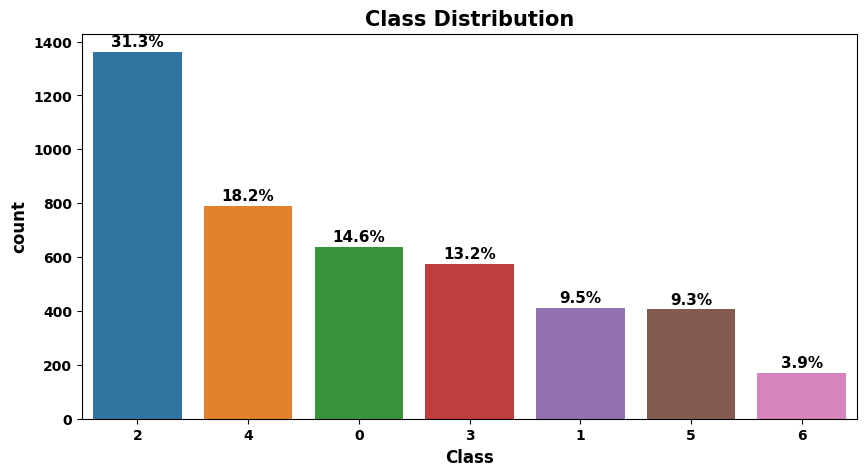

In [13]:
countplot(10,5,'labels',15,0,'Class','Class Distribution')

In [14]:
train_df.groupby('labels').size()

labels
0     637
1     412
2    1361
3     575
4     790
5     406
6     171
dtype: int64

In [15]:
from sklearn.utils import resample

# Set the target number of instances for minority classes
target_minority_count = 200

for minority_class in [0,1,3,5,6]:
    minority_indices = train_df[train_df['labels'] == minority_class].index
    minority_data = train_df.loc[minority_indices]
    
    minority_oversampled = resample(
        minority_data,
        replace=True,
        n_samples=target_minority_count,
        random_state=42
    )
    
    train_df = pd.concat([train_df, minority_oversampled], ignore_index=True)

In [16]:
train_df.groupby('labels').size()

labels
0     837
1     612
2    1361
3     775
4     790
5     606
6     371
dtype: int64

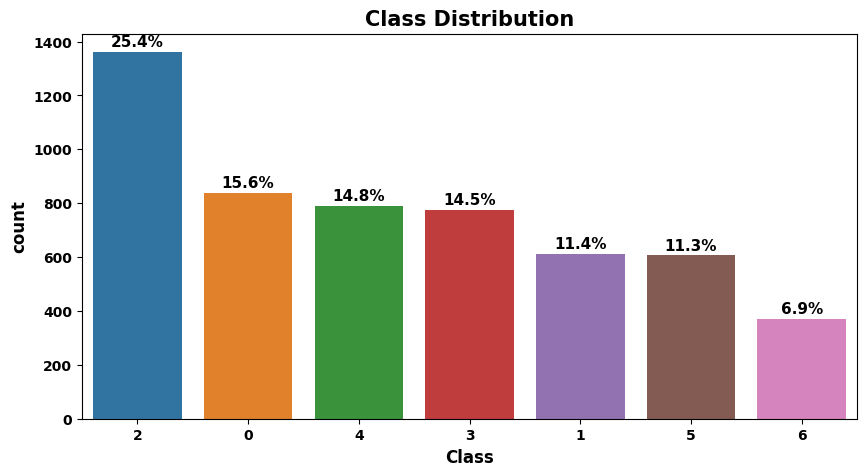

In [17]:
countplot(10,5,'labels',15,0,'Class','Class Distribution')

In [18]:
class Config:
    NUM_EPOCHS = 15
    BATCH_SIZE = 32
    MODEL_PATH = "FacebookAI/xlm-roberta-base"
    LR = 2e-5
    DROPOUT = 0.3
    NUM_CLASSES = 7
    SEED = 42
    MAX_LEN = 120
    DEVICE =  "cuda" if torch.cuda.is_available() else "cpu"

config  = Config()

In [19]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_PATH)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

<Axes: ylabel='Count'>

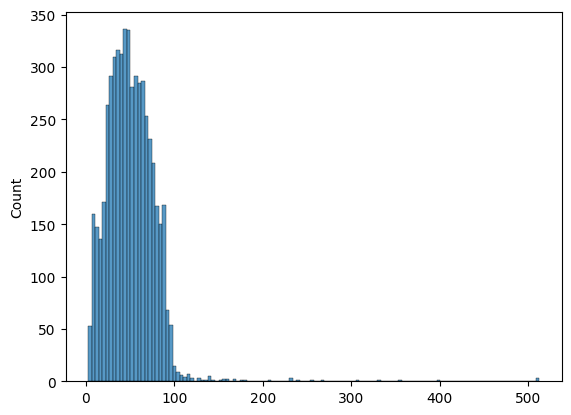

In [20]:
token_counts = []

for _, row in train_df.iterrows():
    text = str(row["content"])  # Ensure the text is converted to a string
    token_count = len(tokenizer.encode(
        text,
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)

sns.histplot(token_counts)

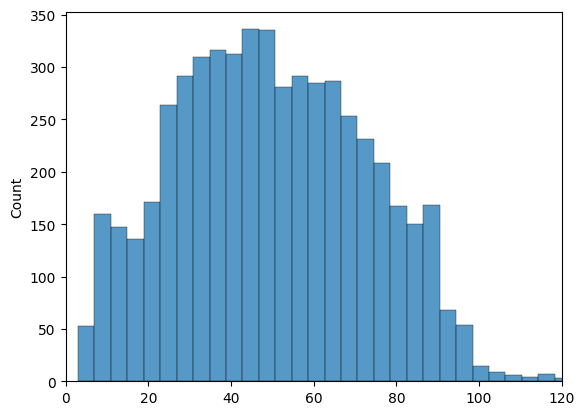

In [21]:
sns.histplot(token_counts)
plt.xlim([0, 120]);

<Axes: ylabel='Count'>

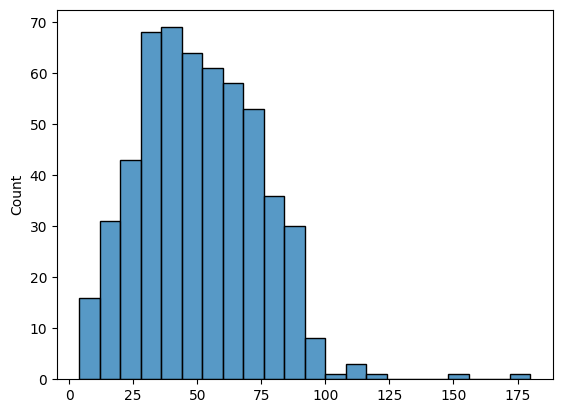

In [22]:
token_counts = []

for _, row in val_df.iterrows():
    text = str(row["content"])  # Ensure the text is converted to a string
    token_count = len(tokenizer.encode(
        text,
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)

sns.histplot(token_counts)

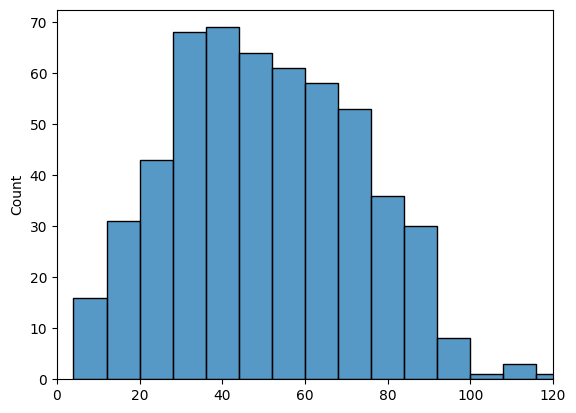

In [23]:
sns.histplot(token_counts)
plt.xlim([0, 120]);

In [24]:
class ClassifierDataset(Dataset):
    def __init__(self, df,tokenizer):
        super(ClassifierDataset, self).__init__()
        self.df = df 
        self.labels = torch.tensor(df.labels.values, dtype=torch.long)
        self.tokenizer = tokenizer
        self.max_length = config.MAX_LEN

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = str(self.df.iloc[index]["content"])
        inputs = self.tokenizer(
            text,
            padding=True, 
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = inputs["input_ids"].squeeze(0)
        attention_mask = inputs["attention_mask"].squeeze(0)
        labels = self.labels[index]

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

In [25]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [26]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class ClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.config = AutoConfig.from_pretrained(config.MODEL_PATH, output_hidden_states=True)
        self.model = AutoModel.from_pretrained(config.MODEL_PATH, config=self.config)
        
        self.config.hidden_dropout = 0.
        self.config.hidden_dropout_prob = 0.
        self.config.attention_dropout = 0.
        self.config.attention_probs_dropout_prob = 0.
        
        self.pool = MeanPooling()
        self.concat_pool = nn.Linear(self.config.hidden_size*3, self.config.hidden_size)
        self.fc = nn.Linear(self.config.hidden_size, 7)
        
        # defining attention network for attention scores 
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        
        self._init_weights(self.fc)
        self._init_weights(self.concat_pool)
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
            
    def forward(self, input_ids=None, attention_mask=None, **kwargs):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_states = outputs.last_hidden_state
        
        # mean pooled sentence representation
        mean_feature = self.pool(last_hidden_states, attention_mask)
        
        # attention based sentence representation
        weights = self.attention(last_hidden_states)
        attention_feature = torch.sum(weights * last_hidden_states, dim=1)
        
        # CLS Token representation
        cls_token_feature = last_hidden_states[:, 0, :]
        
        # Concat them
        combine_feature = torch.cat([mean_feature, attention_feature, cls_token_feature], dim=-1)
        
        # MLP
        feature = self.concat_pool(combine_feature)
        output = self.fc(feature)
        return output

In [27]:
class Engine:
    def __init__(self, model, optimizer,scheduler = None):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        
    @staticmethod
    def loss_fn(target, pred):
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(pred,target)
        return loss
    
    @staticmethod
    def compute_metrics(labels, pred):
        y_true = labels.cpu().numpy()
        pred = pred.cpu().numpy()
        y_pred = np.argmax(pred, axis = -1)
        f1 = f1_score(y_true, y_pred, average='macro')
        return f1
        
    def train(self, train_dataloader,scaler,num_training_steps):
        self.model.train()
        total_training_loss = 0.0
        progress_bar = tqdm(range(num_training_steps))
        for data in train_dataloader:
            input_ids = data["input_ids"].to(config.DEVICE)
            attention_mask = data["attention_mask"].to(config.DEVICE)            
            target = data["labels"].to(config.DEVICE)
            self.optimizer.zero_grad()
            
            with amp.autocast():
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                
            total_training_loss += loss.item()
            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()
            if self.scheduler:
                self.scheduler.step()
            progress_bar.update(1)
                
        return total_training_loss / len(train_dataloader)
    
    def evaluate(self,eval_dataloader):
        self.model.eval()
        val_loss = 0
        score = 0.0
        with torch.no_grad():
            for data in tqdm(eval_dataloader):
                input_ids = data["input_ids"].to(config.DEVICE)  
                attention_mask = data["attention_mask"].to(config.DEVICE)              
                target = data["labels"].to(config.DEVICE)  
                
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                val_loss += loss.item()
                batch_score = self.compute_metrics(target,pred)
                score+= batch_score
             
            score = score / len(eval_dataloader)
            val_loss = val_loss / len(eval_dataloader)
        
        return score, val_loss

In [28]:
history = defaultdict(list)
def run_training(save_model = False):
    train_dataset = ClassifierDataset(train_df,tokenizer)
    val_dataset = ClassifierDataset(val_df,tokenizer)
    train_loader = DataLoader(train_dataset, batch_size = config.BATCH_SIZE,
                              collate_fn=data_collator, shuffle =True, num_workers=2)    
    val_loader = DataLoader(val_dataset, batch_size = config.BATCH_SIZE,
                            collate_fn=data_collator, shuffle=False, num_workers=2)   
    
    set_random_seed(config.SEED)
    model = ClassifierModel()
    model.to(config.DEVICE)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr= config.LR, weight_decay=0.01)
    # optimizer = create_optimizer(model)
    num_training_steps = config.NUM_EPOCHS * len(train_loader)
    
    scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
    )
    eng = Engine(model, optimizer, scheduler)
    scaler = amp.GradScaler()
    early_stopping_iter = 3
    early_stopping_counter = 0
    best_score = 0.0
    for epoch in range(config.NUM_EPOCHS):
        train_loss = eng.train(train_loader,scaler,num_training_steps)
        val_score,val_loss = eng.evaluate(val_loader)
        
        print(f" Epoch: {epoch + 1} | Training_loss: {round(train_loss,4)} | Val_loss: {round(val_loss,4)} | Val_f1: {round(val_score,4)}")
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        if val_score > best_score:
            best_score = val_score
            early_stopping_counter = 0
            
            if save_model:
                torch.save(model.state_dict(),f"best_model.bin")
        else:
            early_stopping_counter +=1
            
        if early_stopping_counter > early_stopping_iter:
            break
            
    del model
    gc.collect()
            
    return round(best_score,5)

In [29]:
score =run_training(save_model = True)
print(f"Best f1 Score: {score}")

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

  0%|          | 0/2520 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

 Epoch: 1 | Training_loss: 1.7806 | Val_loss: 1.7053 | Val_f1: 0.1657


  0%|          | 0/2520 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

 Epoch: 2 | Training_loss: 1.643 | Val_loss: 1.6203 | Val_f1: 0.1895


  0%|          | 0/2520 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

 Epoch: 3 | Training_loss: 1.551 | Val_loss: 1.6072 | Val_f1: 0.2383


  0%|          | 0/2520 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

 Epoch: 4 | Training_loss: 1.4695 | Val_loss: 1.6827 | Val_f1: 0.2662


  0%|          | 0/2520 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab50a03e9e0><function _MultiProcessingDataLoaderIter.__del__ at 0x7ab50a03e9e0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a

 Epoch: 5 | Training_loss: 1.3514 | Val_loss: 1.6701 | Val_f1: 0.2817


  0%|          | 0/2520 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

 Epoch: 6 | Training_loss: 1.1782 | Val_loss: 1.8447 | Val_f1: 0.2745


  0%|          | 0/2520 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab50a03e9e0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ab50a03e9e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

 Epoch: 7 | Training_loss: 1.0044 | Val_loss: 1.9829 | Val_f1: 0.2946


  0%|          | 0/2520 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

 Epoch: 8 | Training_loss: 0.8332 | Val_loss: 2.2118 | Val_f1: 0.2725


  0%|          | 0/2520 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab50a03e9e0><function _MultiProcessingDataLoaderIter.__del__ at 0x7ab50a03e9e0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a

 Epoch: 9 | Training_loss: 0.7078 | Val_loss: 2.351 | Val_f1: 0.269


  0%|          | 0/2520 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

 Epoch: 10 | Training_loss: 0.5935 | Val_loss: 2.3557 | Val_f1: 0.2767


  0%|          | 0/2520 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

 Epoch: 11 | Training_loss: 0.5116 | Val_loss: 2.5682 | Val_f1: 0.2816
Best f1 Score: 0.29462


In [30]:
model = ClassifierModel()
model_path = f"/kaggle/working/best_model.bin"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [31]:
model.to(config.DEVICE)

ClassifierModel(
  (model): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
      

In [32]:
class ClassifierDataset(Dataset):
    def __init__(self, df,tokenizer):
        super(ClassifierDataset, self).__init__()
        self.df = df 
        self.tokenizer = tokenizer
        self.max_length = config.MAX_LEN

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = str(self.df.iloc[index]["content"])
        inputs = self.tokenizer(
            text,
            padding=True, 
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = inputs["input_ids"].squeeze(0)
        attention_mask = inputs["attention_mask"].squeeze(0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
        }

In [33]:
test_dataset = ClassifierDataset(test_df, tokenizer)

In [34]:
from torch.utils.data import DataLoader
test_dataloader = DataLoader(
    test_dataset, batch_size=64, collate_fn=data_collator
)

In [35]:
model.eval()
y_pred = []
for batch in test_dataloader:
    batch = {k: v.to(config.DEVICE) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(input_ids = batch["input_ids"],attention_mask = batch["attention_mask"])
        batch_preds = torch.argmax(outputs, dim=-1)
        y_pred.extend(batch_preds.cpu().numpy().tolist()) 

In [36]:
test_df.shape

(544, 3)

In [37]:
len(y_pred)

544

In [38]:
y_test= test_df['labels'].values

In [39]:
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, classification_report
)
# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
macro_f1 = f1_score(y_test, y_pred, average='macro')

macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')

accuracy = accuracy_score(y_test, y_pred)
# Print metrics
print("Macro F1 Score:", macro_f1)
print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Accuracy:", accuracy)

Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.14      0.17        70
           1       0.13      0.12      0.12        51
           2       0.43      0.60      0.50       171
           3       0.32      0.25      0.28        75
           4       0.48      0.42      0.45       106
           5       0.15      0.11      0.13        46
           6       0.88      0.92      0.90        25

    accuracy                           0.38       544
   macro avg       0.37      0.36      0.36       544
weighted avg       0.36      0.38      0.37       544

Confusion Matrix:
 [[ 10   7  28  11   8   6   0]
 [  8   6  22   6   4   5   0]
 [ 11  10 102  14  22  10   2]
 [  6  11  32  19   7   0   0]
 [  9   8  33   5  44   7   0]
 [  5   4  21   4   6   5   1]
 [  1   0   1   0   0   0  23]]
Macro F1 Score: 0.3638235203491141
Macro Precision: 0.3712705633198035
Macro Recall: 0.3648741078401051
Accuracy: 0.38419117647058826


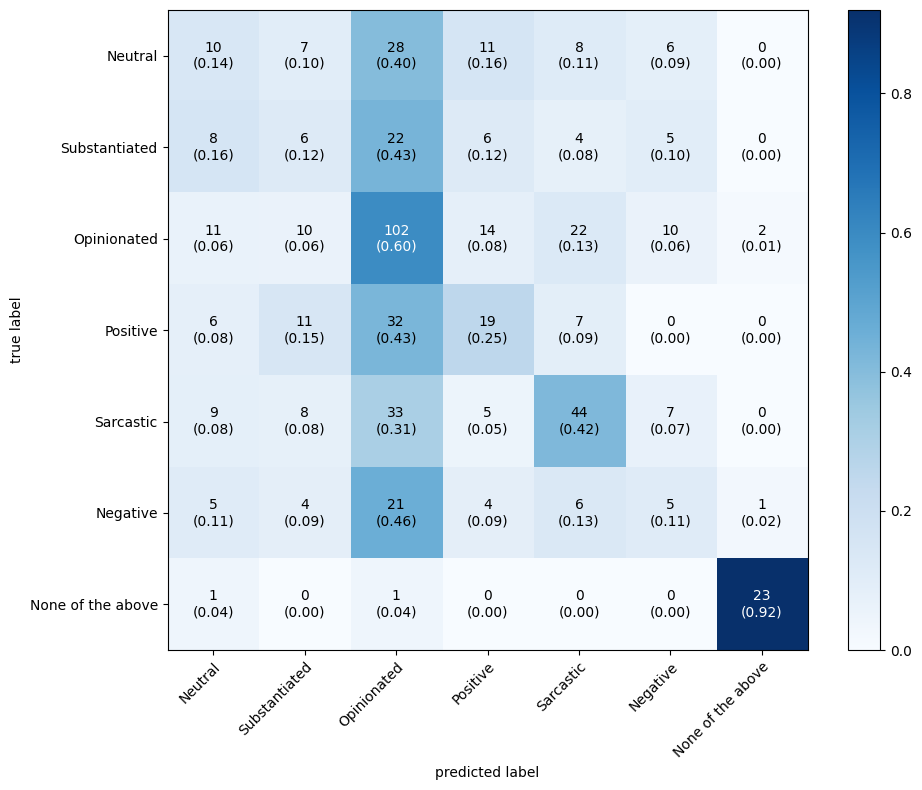

In [41]:
import torch
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

# Convert predictions and true labels to PyTorch tensors if they aren't already
y_pred = torch.tensor(y_pred) if not isinstance(y_pred, torch.Tensor) else y_pred
y_test = torch.tensor(y_test) if not isinstance(y_test, torch.Tensor) else y_test

# Ensure tensors are of type Long (required for classification)
y_pred = y_pred.long()
y_test = y_test.long()

# Create and compute confusion matrix
cmat = ConfusionMatrix(task="multiclass", num_classes=7)
confusion_matrix = cmat(y_pred, y_test)

# Create the confusion matrix plot
fig, ax = plot_confusion_matrix(
    conf_mat=confusion_matrix.cpu().numpy(),
    class_names=[
        'Neutral',
        'Substantiated',
        'Opinionated',
        'Positive',
        'Sarcastic',
        'Negative',
        'None of the above'
    ],
    show_normed=True,
    colorbar=True,
    figsize=(10, 8)  # Make the plot a bit larger for better readability
)

# Rotate the x-axis labels and adjust layout
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()  # Prevent label cutoff

# Show the plot
plt.show()

In [ ]:
# test_df.head()

In [ ]:
# test_df['Labels'] = pred

In [ ]:
# test_df.head()

In [ ]:
# labeling = {
#      0:'Neutral',
#      1:'Substantiated',
#      2:'Opinionated',
#      3:'Positive',
#      4:'Sarcastic',
#      5:'Negative',
#      6:'None of the above'
# }
# test_df['Labels'] = test_df['Labels'].apply(lambda x : labeling[x])

In [ ]:
# test_df.head()

In [ ]:
# test_df.drop(columns = ['content'], inplace = True)

In [ ]:
# test_df.to_csv("KCRL_Tamil.csv", index = False)

In [ ]:
# y_true = val_df.labels.values
# y_pred = pred

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# print(confusion_matrix(y_true, y_pred))

In [ ]:
# from sklearn.metrics import (
#     classification_report,
#     confusion_matrix,
#     f1_score,
#     accuracy_score,
#     precision_score,
#     recall_score
# )

# # Print the classification report
# print("Classification Report:\n", classification_report(y_true, y_pred))

# # Print the confusion matrix
# print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# # Calculate individual metrics for weighted and macro averages
# weighted_f1 = f1_score(y_true, y_pred, average='weighted')
# macro_f1 = f1_score(y_true, y_pred, average='macro')

# weighted_precision = precision_score(y_true, y_pred, average='weighted')
# macro_precision = precision_score(y_true, y_pred, average='macro')

# weighted_recall = recall_score(y_true, y_pred, average='weighted')
# macro_recall = recall_score(y_true, y_pred, average='macro')

# accuracy = accuracy_score(y_true, y_pred)

# # Print metrics
# print("Weighted F1 Score:", weighted_f1)
# print("Macro F1 Score:", macro_f1)
# print("Weighted Precision:", weighted_precision)
# print("Macro Precision:", macro_precision)
# print("Weighted Recall:", weighted_recall)
# print("Macro Recall:", macro_recall)
# print("Accuracy:", accuracy)

In [ ]:
# import torch
# import matplotlib.pyplot as plt
# from mlxtend.plotting import plot_confusion_matrix
# from torchmetrics import ConfusionMatrix
# y_pred = torch.tensor(y_pred)
# y_true = torch.tensor(y_true)

# cmat = ConfusionMatrix(task="multiclass", num_classes=7)
# confusion_matrix = cmat(y_pred, y_true)

# fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix.cpu().numpy(),
#                                 class_names=[0,1,2,3,4,5,6],
#                                 show_normed=True,
#                                 colorbar=True)

# # Rotate the x-axis labels
# plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

# # Show the plot
# plt.show()